<a href="https://colab.research.google.com/github/ClaudioAresu/TensorFlow/blob/main/04transfer_learning_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, BinaryCrossentropy
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Are we using a GPU?

!nvidia-smi

Wed Feb 22 16:00:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Load the file and unzip it

import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-02-22 16:02:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.7MB/s    in 7.9s    

2023-02-22 16:02:59 (20.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#How many images in each folder

import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} and {len(filenames)} images in the '{dirpath}'.")

There are 2 and 0 images in the '10_food_classes_10_percent'.
There are 10 and 0 images in the '10_food_classes_10_percent/test'.
There are 0 and 250 images in the '10_food_classes_10_percent/test/fried_rice'.
There are 0 and 250 images in the '10_food_classes_10_percent/test/sushi'.
There are 0 and 250 images in the '10_food_classes_10_percent/test/chicken_curry'.
There are 0 and 250 images in the '10_food_classes_10_percent/test/chicken_wings'.
There are 0 and 250 images in the '10_food_classes_10_percent/test/pizza'.
There are 0 and 250 images in the '10_food_classes_10_percent/test/steak'.
There are 0 and 250 images in the '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 and 250 images in the '10_food_classes_10_percent/test/ramen'.
There are 0 and 250 images in the '10_food_classes_10_percent/test/hamburger'.
There are 0 and 250 images in the '10_food_classes_10_percent/test/ice_cream'.
There are 10 and 0 images in the '10_food_classes_10_percent/train'.
There are 0 a

## Creating the data loaders (preparing the data)

We'll use the ImageDataGenerator calss to load in our images in batches

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          )

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          )

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

Callbacks are extra functionalities you can add to your models to be performed during or after training. Some of the most popular callbacks:

* TensorBoard
* Model Checkpointing
* Early Stopping


In [ ]:
 #Create TensorBoard callback *functioniezed because we need to create a new one for each model
 import datetime

 def create_tensorboard_callback(dir_name, experiment_name):
   log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
   tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
   print(f"Saving TensorBoarad log files to: {log_dir}")
   return tensorboard_callback

## Creating models unsing TensorFlow Hub

in the past we've used TensorFlow to create our own models layer by layer forom scratch.

Now we're going to do a similar process, except the majority of our models' layers are going to come from TensorFlow Hub

Browsing the TensorFlow Hub page and sorting for image classification, we've found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

**Note:**
* https://paperswithcode.com/
* https://tfhub.dev/ 

In [ ]:
#Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
#Import dependencies
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFLow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with  model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """

  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  
  model = Sequential([
      feature_extraction_layer,
      Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [ ]:
# Create Resnet model

resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             25615849  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25,625,869
Trainable params: 10,020
Non-trainable params: 25,615,849
_________________________________________________________________


In [ ]:
#Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [ ]:
history_resnet = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data_10_percent,
                 validation_steps=len(test_data_10_percent),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V2")],
                 verbose=2)

Saving TensorBoarad log files to: tensorflow_hub/resnet50V2/20230222-171326
Epoch 1/5
24/24 - 29s - loss: 2.3254 - accuracy: 0.3133 - val_loss: 1.1778 - val_accuracy: 0.6204 - 29s/epoch - 1s/step
Epoch 2/5
24/24 - 16s - loss: 0.9600 - accuracy: 0.7013 - val_loss: 0.9017 - val_accuracy: 0.7016 - 16s/epoch - 678ms/step
Epoch 3/5
24/24 - 16s - loss: 0.6923 - accuracy: 0.7693 - val_loss: 0.8272 - val_accuracy: 0.7196 - 16s/epoch - 651ms/step
Epoch 4/5
24/24 - 24s - loss: 0.5259 - accuracy: 0.8440 - val_loss: 0.7932 - val_accuracy: 0.7300 - 24s/epoch - 998ms/step
Epoch 5/5
24/24 - 16s - loss: 0.4315 - accuracy: 0.8720 - val_loss: 0.7696 - val_accuracy: 0.7432 - 16s/epoch - 659ms/step


In [ ]:
#Let's create a function to visualize our loss and accuracy curves...

def plot_loss_curve(history):
  """
  Returns separate loss curves for trainings and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure()
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

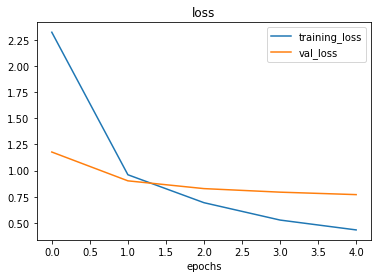

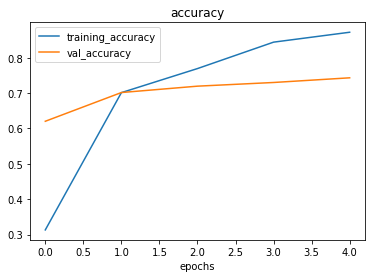

In [ ]:
plot_loss_curve(history=history_resnet)

In [ ]:
efficientnet_model = create_model(efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [ ]:
history_efficientnet = efficientnet_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data_10_percent,
                       validation_steps=len(test_data_10_percent),
                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                             experiment_name="EfficientNetB0")],
                       verbose=2)

Saving TensorBoarad log files to: tensorflow_hub/EfficientNetB0/20230222-181114
Epoch 1/5
24/24 - 24s - loss: 0.4519 - accuracy: 0.8987 - val_loss: 0.5269 - val_accuracy: 0.8680 - 24s/epoch - 1s/step
Epoch 2/5
24/24 - 17s - loss: 0.3969 - accuracy: 0.9200 - val_loss: 0.4988 - val_accuracy: 0.8724 - 17s/epoch - 696ms/step
Epoch 3/5
24/24 - 15s - loss: 0.3539 - accuracy: 0.9307 - val_loss: 0.4773 - val_accuracy: 0.8768 - 15s/epoch - 622ms/step
Epoch 4/5
24/24 - 15s - loss: 0.3185 - accuracy: 0.9373 - val_loss: 0.4613 - val_accuracy: 0.8760 - 15s/epoch - 615ms/step
Epoch 5/5
24/24 - 17s - loss: 0.2874 - accuracy: 0.9493 - val_loss: 0.4470 - val_accuracy: 0.8780 - 17s/epoch - 701ms/step


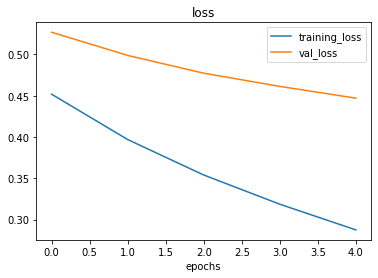

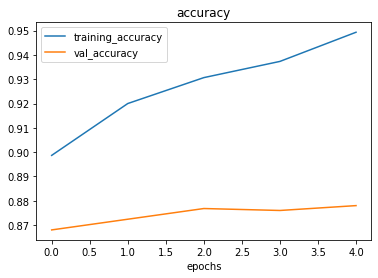

In [ ]:
plot_loss_curve(history_efficientnet)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


##  Different types of transfer learning

* "As is" transfer learning - using an existing model with no changes whatsoever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)

* "Feature extraction" transfer learning - use the prelearned patterns of an existing model (e.g. EfficnetNetB0 trained on ImageNet) and adjust output layer for your own problem (e.g. 1000 classes

* "Fine tuning" transfer learning - use the prelearned patterns fo an existing model and "fine-tune  many or all of the underlying layers (including new output layers)

In [ ]:
len(efficientnet_model.layers[0].weights)

309

In [ ]:
#Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. REsNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

In [ ]:
!tensorboard dev list

In [ ]:
# !tensorboard dev delete --experiment id